In [27]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, recall_score, plot_roc_curve
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import pickle
import warnings
warnings.simplefilter('ignore')
import joblib

from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier

from sklearn.neural_network import MLPClassifier

In [5]:
df = pd.read_csv('../data/processed/modified1.csv', index_col=[0])

In order to perform encoding, it's necessary to get rid of the missing values. 

Admission_source and weight have a lot of missing values. On a first iteration I'll drop these columns. Also, as I have a good dataset size, I can erase registers containing missing values.

In [6]:
df = df.drop(columns = ['admission_type_id','weight'])

In [7]:
df = df.dropna(subset=['race','diag_1','diag_2','diag_3'])

In [8]:
cat_features = ['race','gender','discharge_disposition_id','admission_source_id','medical_specialty','diag_1','diag_2','diag_3','max_glu_serum','A1Cresult','metformin','glimepiride','glipizide','glyburide','pioglitazone','rosiglitazone','insulin','change','diabetesMed']

num_features = ['age','time_in_hospital','num_medications','number_outpatient','number_emergency','number_inpatient','requests_1','requests_10']

y = ['readmitted']

X = cat_features+num_features

In [9]:
X_train, X_test, y_train, y_test = train_test_split(df[X], df[y], test_size=0.30, random_state=27)

In [11]:
X_test.to_csv('../data/processed/X_test.csv')
y_test.to_csv('../data/processed/y_test.csv')

In [14]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', MinMaxScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_features),
        ('cat', categorical_transformer, cat_features)])

In [20]:
def metrics(y_test, y_pred):
    '''Generate f1, recall, accuracy and the confusion matrix for y_test / y_pred'''
    f1 = f1_score(y_test,y_pred)
    rec = recall_score(y_test,y_pred)
    acc = accuracy_score(y_test,y_pred)
    cm = confusion_matrix(y_test, y_pred)

    return f1, rec, acc, cm

## Logistic Regresion

In [23]:
if os.path.exists('../models/lr1.pkl'):
    lr1 = joblib.load('../models/lr1.pkl')

else:
    lr1 = Pipeline(steps=[('preprocessor', preprocessor),
                        ('classifier', LogisticRegression(random_state=1))])
    lr1.fit(X_train,y_train)

    joblib.dump(lr1, '../models/lr1.pkl')

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['age', 'time_in_hospital',
                                                   'num_medications',
                                                   'number_outpatient',
                                                   'number_emergency',
                                                   'number_inpatient',
                                                   'requests_1',
                                                   'requests_10']),
                                                 ('cat',
               

In [33]:
y_pred = lr1.predict(X_test)
lr_f1, lr_rec, lr_acc, lr_cm = metrics(y_test,y_pred)

## Random Forest Classifier

In [38]:
if os.path.exists('../models/rf1.pkl'):
    rf1 = joblib.load('../models/rf1.pkl')
else:
    rf1 = Pipeline(steps=[('preprocessor', preprocessor),
                        ('classifier', RandomForestClassifier(random_state=1))])
    rf1.fit(X_train,y_train)

    joblib.dump(rf1, '../models/rf1.pkl')

In [39]:
y_pred = rf1.predict(X_test)
rf_f1, rf_rec, rf_acc, rf_cm = metrics(y_test,y_pred)

<AxesSubplot:ylabel='feature'>

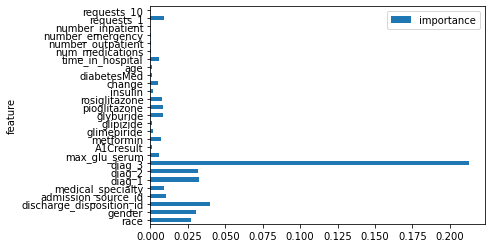

In [40]:
fi = list(zip(X_train.columns.values, rf1.steps[1][1].feature_importances_))
pd.DataFrame(columns = ['feature', 'importance'], data = fi).plot.barh(x='feature', y='importance')

## Decision Tree

In [42]:
if os.path.exists('../models/dt1.pkl'):
    dt1 = joblib.load('../models/dt1.pkl')
    
else:    
    dt1 = Pipeline(steps=[('preprocessor', preprocessor),
                        ('classifier', DecisionTreeClassifier())])
    dt1.fit(X_train,y_train)

    joblib.dump(dt1, '../models/dt1.pkl')

In [43]:
y_pred = dt1.predict(X_test)
dt_f1, dt_rec, dt_acc, dt_cm = metrics(y_test,y_pred)

<AxesSubplot:ylabel='feature'>

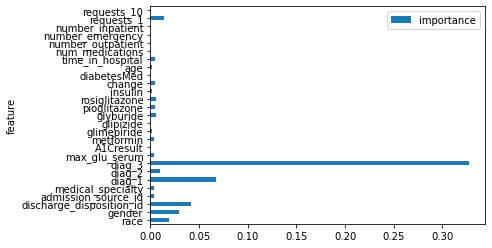

In [44]:
fi = list(zip(X_train.columns.values, dt1.steps[1][1].feature_importances_))
pd.DataFrame(columns = ['feature', 'importance'], data = fi).plot.barh(x='feature', y='importance')

## Neural Net

In [15]:
if os.path.exists('../models/NN.pkl'):
    NN = joblib.load('../models/NN.pkl')

else:
    NN = Pipeline(steps=[('preprocessor', preprocessor),
                        ('classifier', MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(100), random_state=1))])
                      
    NN.fit(X_train, y_train)

    joblib.dump(NN, '../models/NN.pkl')

                      
if os.path.exists('../models/NN2.pkl'):
    NN2 = joblib.load('../models/NN2.pkl')

else:    
    NN2 = Pipeline(steps=[('preprocessor', preprocessor),
                        ('classifier', MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(10, 7, 3), random_state=1))])
    
    NN2.fit(X_train, y_train)

    joblib.dump(NN2, '../models/NN2.pkl')

In [21]:
y_pred = NN.predict(X_test)
NN_f1, NN_rec, NN_acc, NN_cm = metrics(y_test,y_pred)

y_pred = NN2.predict(X_test)
NN2_f1, NN2_rec, NN2_acc, NN2_cm = metrics(y_test,y_pred)

## Comparison of the models

In [47]:
data = {'Model':['LogisticRegression','RandomForest','Decision Tree', 'NN 1 Hidden Layer', 'NN 3 Hidden Layers'],
    'Accuracy':[lr_acc,rf_acc,dt_acc, NN_acc, NN2_acc], 
    'Recall':[lr_rec,rf_rec,dt_rec, NN_rec, NN2_rec], 
    'F1':[lr_f1,rf_f1,dt_f1, NN_f1, NN2_f1]}
comp = pd.DataFrame(data)

In [48]:
comp

,Model,Accuracy,Recall,F1
0,LogisticRegression,0.750918,0.617395,0.698911
1,RandomForest,0.798273,0.748003,0.776413
2,Decision Tree,0.733206,0.705024,0.712211
3,NN 1 Hidden Layer,0.750272,0.684333,0.719597
4,NN 3 Hidden Layers,0.726271,0.621751,0.680222


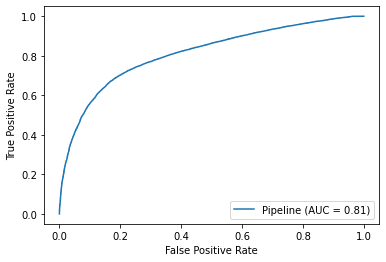

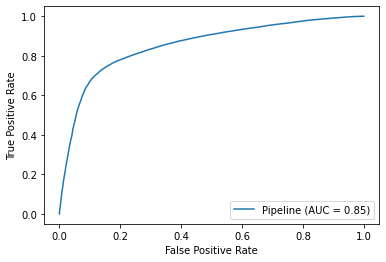

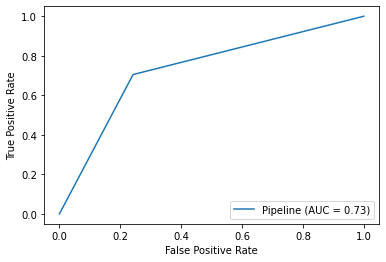

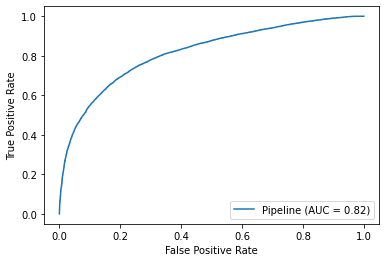

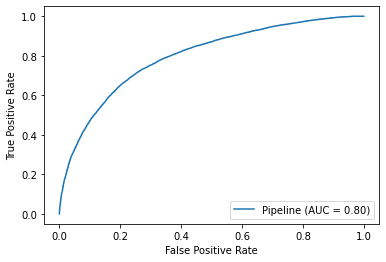

In [50]:
plot_roc_curve(lr1,X_test,y_test)
plot_roc_curve(rf1,X_test,y_test)
plot_roc_curve(dt1,X_test,y_test)
plot_roc_curve(NN, X_test, y_test)
plot_roc_curve(NN2, X_test, y_test)

#### Conclusion: The best of the proposed model for comparison was the Random Forest Classifier. It was the best on the overall metrics, but also it has the best ROC Curve and the best numbers on the confusion matrix. I'll select this model to perform hyperparameter tunning.

## Hyperparameter tunning

In [29]:
parameters = {
  'n_estimators':[1,10,100,1000],
  'min_samples_split': [2,3,4,5]
  }

rf2 = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', GridSearchCV(RandomForestClassifier(),parameters,cv=2,refit=True))])
rf2.fit(X_train,y_train)

/home/sant_vel/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/sant_vel/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/sant_vel/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/sant_vel/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: Dat

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['age', 'time_in_hospital',
                                                   'num_medications',
                                                   'number_outpatient',
                                                   'number_emergency',
                                                   'number_inpatient',
                                                   'requests_1',
                                                   'requests_10']),
                                                 ('cat',
               

In [32]:
y_pred = rf2.predict(X_test)
rf2_f1, rf2_rec, rf2_acc, rf2_cm = metrics(y_test,y_pred)

In [36]:
data = {'Model':['Best RF'],
    'Accuracy':[rf2_acc], 
    'Recall':[rf2_rec], 
    'F1':[rf2_f1]}
pd.DataFrame(data)

,Model,Accuracy,Recall,F1
0,Best RF,0.800313,0.752432,0.77919


In [30]:
import joblib

joblib.dump(rf2,'../models/best.pkl')

['../models/best.pkl']